## Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

 * В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
 * Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
 * Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

### Задание №1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

#### Анализ и предобработка данных

In [2]:
problem1_reg_data = (r"C:\Users\Alex\Karpov\FInal Project\var1\problem1-reg_data.csv")
problem1_auth_data = (r"C:\Users\Alex\Karpov\FInal Project\var1\problem1-auth_data.csv")

In [3]:
reg_data = pd.read_csv(problem1_reg_data, sep=';') # данные о времени регистрации
auth_data = pd.read_csv(problem1_auth_data, sep=';') # данные о времени захода пользователей в игру

In [4]:
reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s') 
auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s')

In [5]:
reg_data.uid.nunique()

1000000

In [6]:
auth_data.uid.nunique()

1000000

In [7]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

#### Я решил отказаться от дф с регистрацией, так как эту информацию можно увидеть в дф с авторизацией

In [8]:
def RR(auth_data, first_reg_date, last_reg_date):
    
    #считываем файл и записываем его в переменную "auth_data"
    auth_data = pd.read_csv(auth_data, sep=';')
    
    #переводим UNIX в формат времени
    auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s')
    
    # получаем дф с регистрацией
    start_day = auth_data.groupby('uid',as_index=False)[['auth_ts']].min().rename(columns={'auth_ts':'start_day'})
    start_day.start_day = start_day.start_day.dt.date
    start_day.start_day = pd.to_datetime(start_day.start_day)
    # start_day.start_day = start_day.start_day.astype("datetime64") так тоже норм
    
    # немножко преобразуем дату в дф с авторизацией
    auth_data.auth_ts = auth_data.auth_ts.dt.date
    auth_data.auth_ts = auth_data.auth_ts.astype("datetime64")
    auth_data = auth_data.rename(columns={'auth_ts':'auth_day'})
    
    # соединим таблицы
    df = auth_data.merge(start_day, how='left', on='uid').reindex(columns =['uid','auth_day','start_day'])
    
    # добавим колонку с разницей дней с момента регистрации до авторизации каждого юзера
    df['days_since_start'] = (df.auth_day - df.start_day).dt.days 
    
    # выберем пользователей за определенный промежуток времени
    df = df.query('start_day >= @first_reg_date and auth_day < @last_reg_date')
    
    # разделим пользователей на когорты и посчитаем Retention
    df = df.groupby(['start_day','days_since_start'],as_index=False).agg({'uid':'nunique'}).rename(columns={'start_day':'cohort',\
                                                                                                     'days_since_start':'days',\
                                                                                                                  'uid':'amount'})
    df = df.pivot(index='cohort', columns='days', values='amount')
    RR = df.divide(df[0],axis=0)
    
    # строим график
    plt.figure(figsize=(18,14))
    plt.title('Retention Rate',fontsize = 18)
    ax = sns.heatmap(data=RR, annot=True, fmt='.0%', vmin=0.0, vmax=0.1, cmap="viridis")
    ax.set_yticklabels(RR.index.strftime('%Y-%m-%d'),fontsize=12)
    ax.set_xticklabels(RR.columns, fontsize = 12)
    fig=ax.get_figure()
    plt.show()
    
    
    return ax


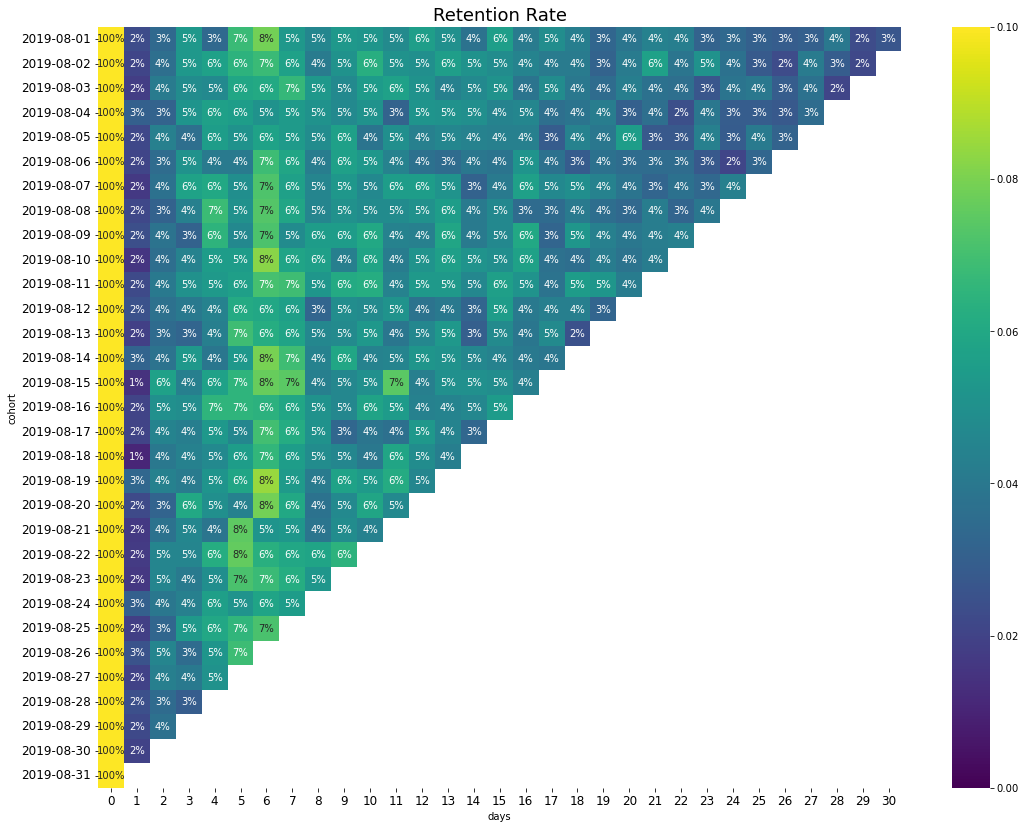

<AxesSubplot:title={'center':'Retention Rate'}, xlabel='days', ylabel='cohort'>

In [9]:
auth_data = (r"C:\Users\Alex\Karpov\FInal Project\var1\problem1-auth_data.csv")
first_reg_date = '2019-08'
last_reg_date = '2019-09'
RR(auth_data, first_reg_date, last_reg_date)

### Задание №2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


from scipy import stats
import scipy.stats as ss
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu

%matplotlib inline 

In [11]:
sns.set(font_scale = 2, style ="darkgrid")

In [12]:
df = pd.read_csv(r'C:\Users\Alex\Karpov\FInal Project\var1\Проект_1_Задание_2.csv',sep=';')

In [13]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [14]:
# посмотрим на наличие пропусков
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [16]:
df.user_id.nunique() # повторных ID нет

404770

In [17]:
# кол-во пользователей
df.groupby('testgroup',as_index=False)[['user_id']].agg('nunique')

,testgroup,user_id
0,a,202103
1,b,202667


In [18]:
# кол-во платящих пользователей
df.query('revenue > 0').groupby('testgroup',as_index=False)[['user_id']].agg('nunique')

,testgroup,user_id
0,a,1928
1,b,1805


#### Судя по данным:
 * а - контрольная группа
 * b - тестовая группа

Посчитаем ARPU для каждой из групп:

In [19]:
df.groupby('testgroup').revenue.mean()

testgroup
a    25.413720
b    26.751287
Name: revenue, dtype: float64

In [20]:
#посчитаем разницу ARPU между группами
a_ARPU = df.query('testgroup == "a"').revenue.mean()
b_ARPU = df.query('testgroup == "b"').revenue.mean()

In [21]:
round((b_ARPU - a_ARPU)/a_ARPU*100,2)

5.26

#### Действительно ARPU тестовой группы вырос на 5%

In [22]:
# посмотрим на распределение платящих пользователей
a = df.query('testgroup == "a" and revenue > 0')
b = df.query('testgroup == "b" and revenue > 0')

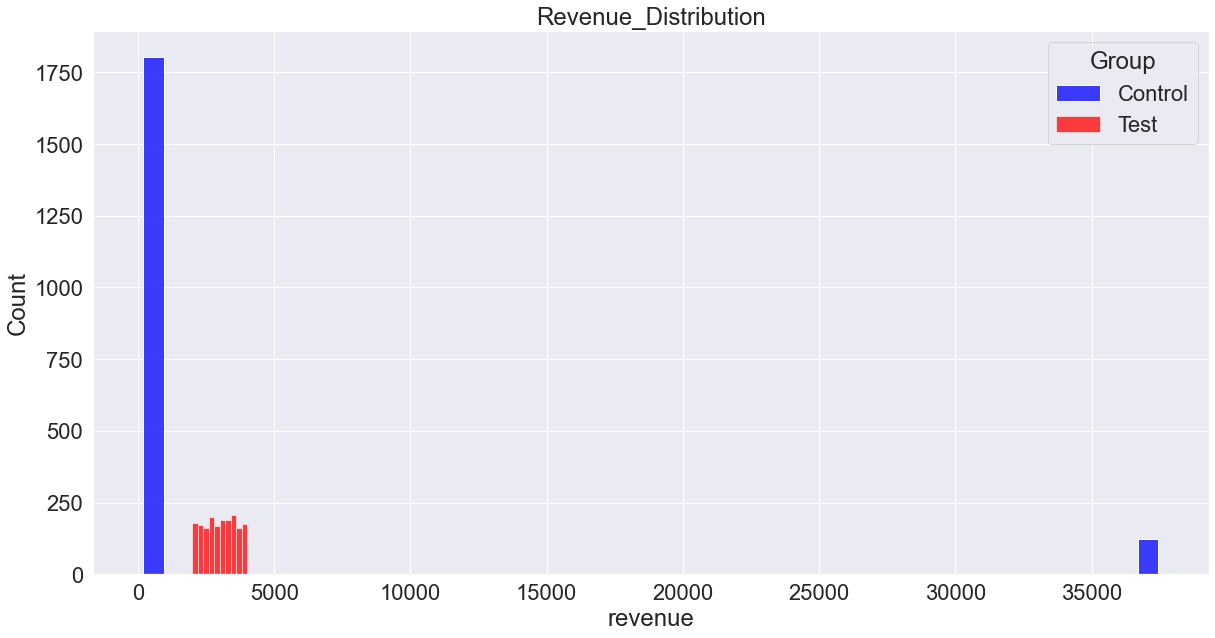

In [23]:
plt.figure(figsize=(20,10))
sns.histplot(data=a, x='revenue', color='blue',bins = 50)
sns.histplot(data=b, x='revenue', color='red', bins=10)
plt.title('Revenue_Distribution')  
plt.legend(title='Group', labels=['Control', 'Test'])

In [24]:
# узнаем кол-во пользователей которые платят так много
a.query('revenue > 30000').revenue.count()

123

In [25]:
# интересно узнать % выручки от этих пользователей
round(a.query('revenue > 30000').revenue.sum()/a.revenue.sum()*100,2)

89.37

In [26]:
b.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Цифры выше говорят нам о том, что в контрольной группе из 202103 только 123 пользователя платят нам около 90% всей выручки, при том что остальные пользователи платят очень мало. 

В тестовой же группе, все платежеспособные пользователи (1805 чел) платят нам стабильно от 2000 до 4000.

In [27]:
print(stats.shapiro(a.revenue))
print(stats.shapiro(b.revenue))

ShapiroResult(statistic=0.26679253578186035, pvalue=0.0)
ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)


p-value < 0.05, поэтому отклоняем нулевую гипотезу о нормальном распределениии данных в двух выборках (хотя в контрольной группе это видно невооруженным глазом)

Так как оба распределения не являются нормальными, попробуем провести тест Манна-Уитни:

In [28]:
# для всех пользователей
ss.mannwhitneyu(df.query('testgroup == "a"').revenue, df.query('testgroup == "b"').revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

p-value > 0.05 - отвергнуть нулевую гипотезу об отсутствии разницы между выборками мы не можем

In [29]:
# для платящих пользователей 

ss.mannwhitneyu(a.revenue, b.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

p-value < 0.05 - значит выборки отличаются

Теперь применим метод Bootstrap:

In [30]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(12,8))
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

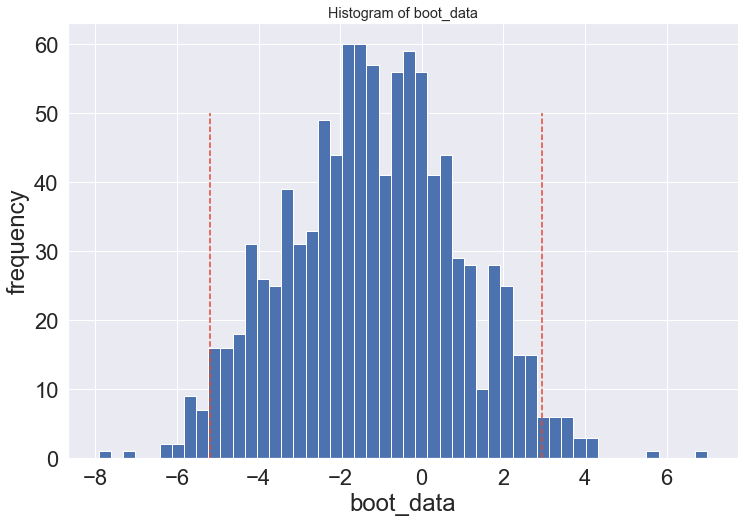

In [31]:
 # бутстрап (с np.mean)
booted_data_mean = get_bootstrap(df.query('testgroup == "a"').revenue, 
                                 df.query('testgroup == "b"').revenue)

In [32]:
# p-value
booted_data_mean['p_value']

0.5768072816421207

Можно сделать вывод, что статистической разницы по ARPU мы не выявили

Теперь проанализируем платящих пользователей

  0%|          | 0/1000 [00:00<?, ?it/s]

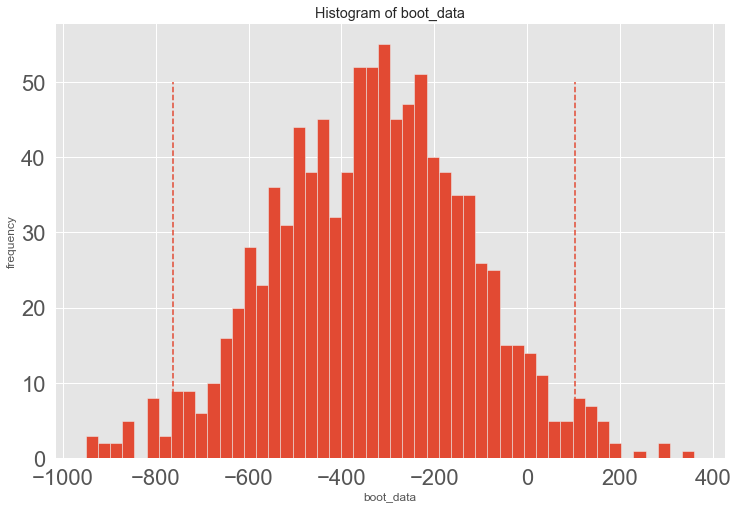

In [33]:
booted_data_mean_pay = get_bootstrap(a.revenue,b.revenue)

In [34]:
booted_data_mean_pay['p_value']

0.1172588822783679

p-value при использовании бутстрапа с np.mean выше 0.05, что говорит нам об отсутствии статистически значимых различий между группами.

#### Вывод: 

На основании проведенного анализа, мы не видим статистически значимой разницы с точки зрения выручки и набор акционных предложений (НАП) не повляил на ARPPU контрольной и тестовой групп. При всем при этом существенно различется распределение оплаты пользователей (об этом я писал выше). И какой оставить НАП - вопрос хороший, но думаю вариант с тестовой группой использовать в дальнейшем проще и удобнее, так как практически все платящие пользователи платят и могут себе это позволить, значит им все нравится, тогда как в контрольной группе акции похоже только для элит, и потерять одного такого такого "элитного" пользователя для нас гораздо страшнее, нежели 2-3 обычных.

### Задание №3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Вариант 1: 
 * ARPPU/ARPU - для оценки прибыли во время события. Возможно игроки будут готовы вложить больше денег, чем обычно для прохождения сложных уровней;
 * DAU и WAU - для анализа кол-ва активных пользователей в период события;
 * RR - для того чтобы мы видели динамику изменения заинтересованности игроков;
 * CR - чтобы видеть конверсию в покупку игроков;
 * Stickiness rate - для оценки регулярности использования приложения в течении тематического события;      

#### Вариант 2(Усложненные механики): 
Нужно проследить за следующими метриками: 
   * среднее время по игрокам за прохождение всех уровней;
   * как много игроков, на каких уровнях и на какое время игроки выходят из игры;

Конечно все эти данные могут негативно повлиять на прибыль